In [57]:
import cv2
import matplotlib.pyplot as plt

image_input = r"C:\Users\abdel\OneDrive\Desktop\MVA\Project RR\closed-form-matting-master\testdata\KNhair.bmp"
image_input = cv2.imread(image_input, cv2.IMREAD_COLOR) 
image=image_input/ 255.0

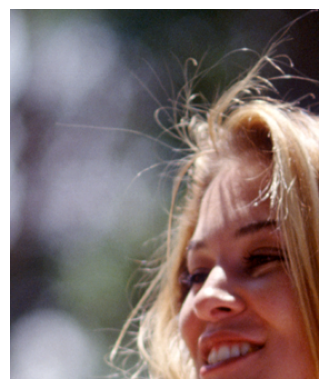

In [58]:
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.show()

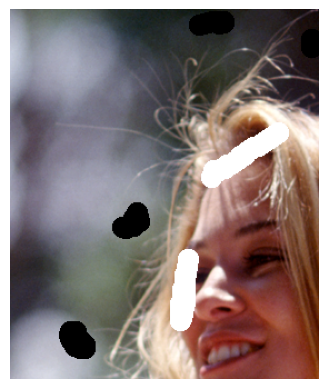

In [59]:
image_scribles = r"C:\Users\abdel\OneDrive\Desktop\MVA\Project RR\closed-form-matting-master\testdata\KNhair_m.bmp"
image_scribles =cv2.imread(image_scribles, cv2.IMREAD_COLOR) 
#image_scribles=image_input

scribbles=image_scribles/ 255.0
plt.imshow(cv2.cvtColor(image_scribles, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.show()

In [74]:
import numpy as np
#We calculate the initial assumption
prior = np.sign(np.sum(image - image, axis=2)) / 2 + 0.5
print(prior)

[[0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 ...
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]


In [77]:
#Constant map 
consts_map = prior != 0.5

print(consts_map)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [65]:
#we calcualte the laplacian 
from scipy.sparse import spdiags, csr_matrix
from scipy.ndimage import binary_erosion

def getLaplacian1(I, consts, epsilon=0.0000001, win_size=1):
    print("calculating the Laplacian ")
    neb_size = (win_size * 2 + 1) ** 2
    h, w, c = I.shape
    img_size = w * h
    consts = binary_erosion(consts, structure=np.ones((win_size * 2 + 1, win_size * 2 + 1)))
    indsM = np.arange(img_size).reshape(h, w)
    tlen = int(((1 - consts[win_size:-win_size, win_size:-win_size]).sum()) * (neb_size ** 2))
    row_inds = np.zeros(tlen)
    col_inds = np.zeros(tlen)
    vals = np.zeros(tlen)
    len_ = 0
    for j in range(win_size, w - win_size):
        for i in range(win_size, h - win_size):
            #if consts[i, j]:
               #continue
            win_inds = indsM[i - win_size:i + win_size + 1, j - win_size:j + win_size + 1]
            win_inds = win_inds.flatten()
            winI = I[i - win_size:i + win_size + 1, j - win_size:j + win_size + 1, :]
            winI = winI.reshape(neb_size, c)
            win_mu = np.mean(winI, axis=0)
            win_var = np.linalg.inv(winI.T @ winI / neb_size - np.outer(win_mu, win_mu) + epsilon / neb_size * np.eye(c))
            winI = winI - win_mu
            tvals = (1 + winI @ win_var @ winI.T) / neb_size
            
            row_inds[len_:len_ + neb_size ** 2] = np.repeat(win_inds, neb_size)
            col_inds[len_:len_ + neb_size ** 2] = np.tile(win_inds, neb_size)
            vals[len_:len_ + neb_size ** 2] = tvals.flatten()
            len_ += neb_size ** 2
    vals = vals[:len_]
    row_inds = row_inds[:len_]
    col_inds = col_inds[:len_]
    A = csr_matrix((vals, (row_inds, col_inds)), shape=(img_size, img_size))
    sumA = A.sum(axis=1)
    A = spdiags(sumA.flatten(), 0, img_size, img_size) - A
    return A

In [76]:
#Apply the function 
laplacian = getLaplacian1(image, consts_map)
print(laplacian)

  (0, 0)	0.6873673956126991
  (0, 1)	-0.23319079715163304
  (0, 2)	0.05083528048237045
  (0, 278)	-0.10645908720716266
  (0, 279)	-0.1398243067484293
  (0, 280)	-0.3377735745590658
  (0, 556)	-0.04795289749412406
  (0, 557)	0.028404581810859857
  (0, 558)	0.09859340525448543
  (1, 0)	-0.23319079715163393
  (1, 1)	0.7369479064697535
  (1, 2)	-0.22946681042502814
  (1, 3)	-0.17222119662264232
  (1, 278)	0.16974670586085727
  (1, 279)	0.11241872764502826
  (1, 280)	0.19452062426914513
  (1, 281)	-0.16530603140933098
  (1, 556)	0.09439863409775567
  (1, 557)	-0.19862001235949373
  (1, 558)	0.006350915561712644
  (1, 559)	-0.3155786659361236
  (2, 0)	0.05083528048237026
  (2, 1)	-0.22946681042502853
  (2, 2)	1.3212249808523882
  (2, 3)	-0.664764472342739
  :	:
  (92571, 92570)	0.06791378457002081
  (92571, 92571)	1.0735031416397116
  (92571, 92572)	-0.15183249306642257
  (92571, 92573)	-0.0002360099964555045
  (92572, 92014)	0.09581149125825944
  (92572, 92015)	-0.2413807700769971
  (92572,

In [67]:
import scipy.sparse
import scipy.sparse.linalg


scribbles_confidence=100
#prior_confidence contains the confidence values where consts_map is True, and zero otherwise
prior_confidence = scribbles_confidence * consts_map
print(prior_confidence)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [68]:
#converts prior_confidence matrix into a sparse diagonal matrix 
confidence = scipy.sparse.diags(prior_confidence.flatten())
print(confidence)

  (735, 735)	100.0
  (736, 736)	100.0
  (737, 737)	100.0
  (738, 738)	100.0
  (739, 739)	100.0
  (740, 740)	100.0
  (741, 741)	100.0
  (742, 742)	100.0
  (743, 743)	100.0
  (744, 744)	100.0
  (745, 745)	100.0
  (746, 746)	100.0
  (747, 747)	100.0
  (748, 748)	100.0
  (749, 749)	100.0
  (750, 750)	100.0
  (751, 751)	100.0
  (1009, 1009)	100.0
  (1010, 1010)	100.0
  (1011, 1011)	100.0
  (1012, 1012)	100.0
  (1013, 1013)	100.0
  (1014, 1014)	100.0
  (1015, 1015)	100.0
  (1016, 1016)	100.0
  :	:
  (87073, 87073)	100.0
  (87074, 87074)	100.0
  (87075, 87075)	100.0
  (87076, 87076)	100.0
  (87077, 87077)	100.0
  (87078, 87078)	100.0
  (87079, 87079)	100.0
  (87080, 87080)	100.0
  (87081, 87081)	100.0
  (87082, 87082)	100.0
  (87083, 87083)	100.0
  (87084, 87084)	100.0
  (87085, 87085)	100.0
  (87086, 87086)	100.0
  (87352, 87352)	100.0
  (87353, 87353)	100.0
  (87354, 87354)	100.0
  (87355, 87355)	100.0
  (87356, 87356)	100.0
  (87357, 87357)	100.0
  (87358, 87358)	100.0
  (87359, 87359)	100

In [69]:
#Computes the solution of the linear system
solution = scipy.sparse.linalg.spsolve(laplacian + confidence,prior.flatten() * prior_confidence.flatten())

In [70]:
#Ensure that the result lie within the range [0, 1]
alpha = np.clip(solution.reshape(prior.shape), 0, 1)

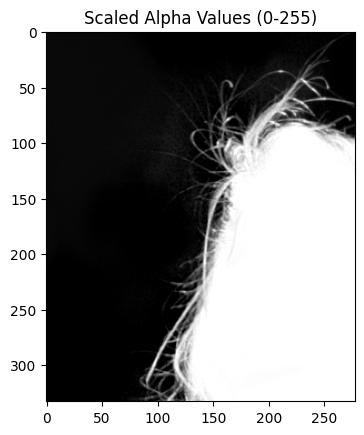

In [71]:
# Plot the scaled alpha values
plt.imshow(alpha * 255, cmap='gray')  # Display as grayscale
plt.title('Scaled Alpha Values (0-255)')
plt.show()